In [1]:
import numpy as np
import matplotlib.pyplot as plt

import functions as fn
from neuron import MHH
from simulation import Simulation

# Figures for the paper

### Create a simulation environment

In [2]:
mySim = Simulation(Sim_period=5000, Sim_fs=100)

### Create a stimulation signal

In [3]:
I_stim = 2 #* 20.5
    
I = I_stim * np.ones(mySim.t.shape)  # pA

slope = fn.gen_slope(init_time=0,
                     end_time=200,
                     time_points=mySim.t)

# Sinusoid
I1 = fn.gen_sin(init_time=0,
                freq=.010,
                phase=0,
                time_points=mySim.t)
# I2 = fn.gen_sin(init_time=50,
#                 freq=.01,
#                 phase=0,
#                 time_points=Sim_t)

# I = slope * (I_stim * (I3 * .1 + I2 * 1) + 0)
I = slope * I_stim * I1



# sinusoid + chirp
I1 = fn.gen_sin(init_time=0,
                freq=1,
                phase=0,
                time_points=mySim.t)
I2 = fn.gen_sin(init_time=0,
                freq=1.01,
                phase=0,
                time_points=mySim.t)

I3, freq = fn.gen_chirp(Chirp_init_freq=1.001, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=1.02, 
                         Chirp_end_time=mySim.t[-1], 
                         time_points=mySim.t)

# freq *= 1000  # change from kHz to Hz
# I = slope * (I_stim * (.5*I1 + .5*I2))

# Chirp stimulation
# out, freq = fn.gen_chirp(Chirp_init_freq=.0001, 
#                          Chirp_init_time=0, 
#                          Chirp_end_freq=.02, 
#                          Chirp_end_time=mySim.t[-1], 
#                          time_points=mySim.t)

# I      = I_stim * out  # pA

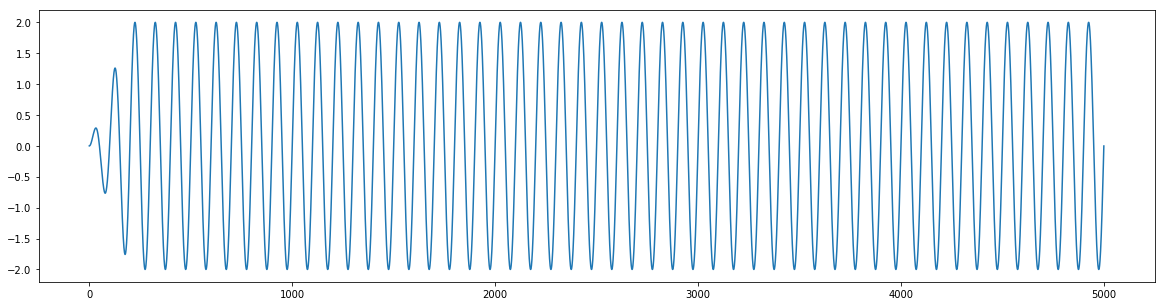

In [8]:
plt.figure(figsize=(20,5))
plt.plot(mySim.t, I)

---

### MHH neuron model

In [4]:
const_params = {
    # variable = value xxx Unit
    'gNA': 240, # m.mho/cm^2
    'gK': 36, # m.mho/cm^2
    'gA': 61, # m.mho/cm^2
    'gL': 0.068, # m.mho/cm^2
    'ENA': 64.7, # mV
    'EK': -95.2, # mV
    'EL': -51.3, # mV
    'C': 1, # uF/cm^2
    'Er': -71,
    'g_L': 10000,
    'L': 1
}

In [5]:
# Na channel: m, h
# delayed-rectifier K current: n
# slow non-inactivating K current: p, a, 
tracked_params = ['m', 'h', 'n', 'p', 'a', 'b', 
                  'u', 'b', 'INA', 'IK', 'IA', 'I_L']

In [6]:
myNeuron = MHH(const_params=const_params,
               tracked_params=tracked_params,
               time_points=mySim.t)

### Run the simulation

In [9]:
for i in range(I.shape[0]-1):
    myNeuron.update(i, mySim.dt)
    
# let's block some currents
#     myNeuron.I[i] = 0
#     myNeuron.INA[i] = 0  # contributing to the integration
#     myNeuron.IK[i] = 0  # not sure what is contributing to!
#     myNeuron.IA[i] = 0  # contributes to stability and bringing down the membrane potential (so integration as well)

    dudt = (myNeuron.INA[i] + myNeuron.IK[i] + myNeuron.IA[i] + myNeuron.IL + I[i]) / myNeuron.C
    myNeuron.u[i+1] = myNeuron.u[i] + mySim.dt * dudt

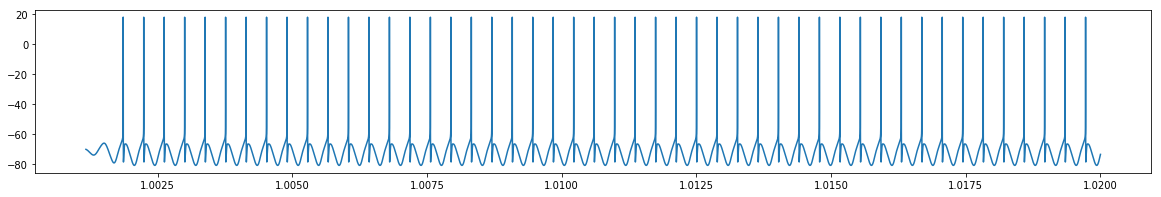

In [10]:
plt.figure(figsize=(20,3))
plt.plot(freq[4500:], myNeuron.u[4500:])
plt.show()

---

#### Figure 3C: MHH response to ZAP input

In [18]:
# Chirp stimulation
I, freq = fn.gen_chirp(Chirp_init_freq=.0001, 
                       Chirp_init_time=0, 
                       Chirp_end_freq=.02, 
                       Chirp_end_time=mySim.t[-1], 
                       time_points=mySim.t)

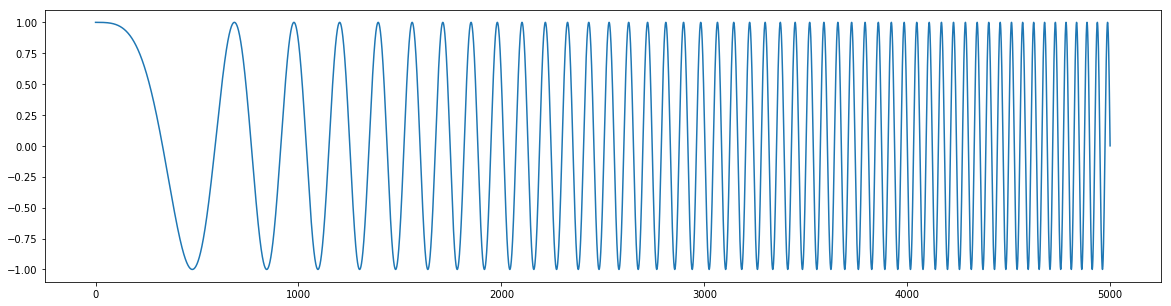

In [19]:
plt.figure(figsize=(20,5))
plt.plot(mySim.t, I)

In [21]:
for i in range(I.shape[0]-1):
    myNeuron.update(i, mySim.dt)
    dudt = (myNeuron.INA[i] + myNeuron.IK[i] + myNeuron.IA[i] + myNeuron.IL + I[i]) / myNeuron.C
    myNeuron.u[i+1] = myNeuron.u[i] + mySim.dt * dudt

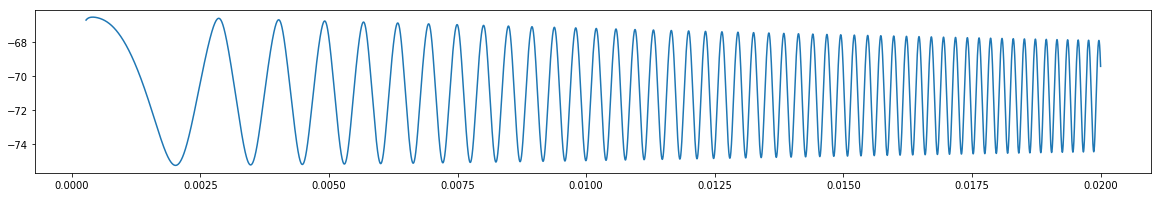

In [22]:
plt.figure(figsize=(20,3))
plt.plot(freq[4500:], myNeuron.u[4500:])
plt.show()

---

#### Figure 3D: MHH neuron response to AMZAP

In [23]:
I1 = fn.gen_sin(init_time=0,
                freq=1.0,
                phase=0,
                time_points=mySim.t)

I2, freq = fn.gen_chirp(Chirp_init_freq=1.001, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=1.02, 
                         Chirp_end_time=mySim.t[-1], 
                         time_points=mySim.t)

I = .5*I1 + .5*I2

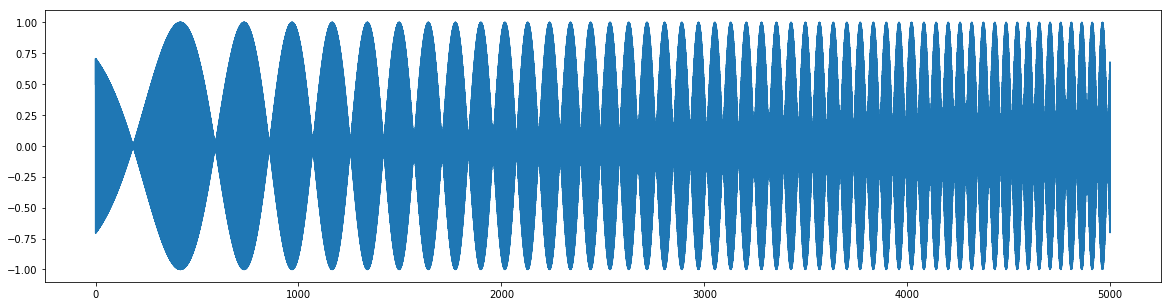

In [24]:
plt.figure(figsize=(20,5))
plt.plot(mySim.t, I)

In [25]:
for i in range(I.shape[0]-1):
    myNeuron.update(i, mySim.dt)
    dudt = (myNeuron.INA[i] + myNeuron.IK[i] + myNeuron.IA[i] + myNeuron.IL + I[i]) / myNeuron.C
    myNeuron.u[i+1] = myNeuron.u[i] + mySim.dt * dudt

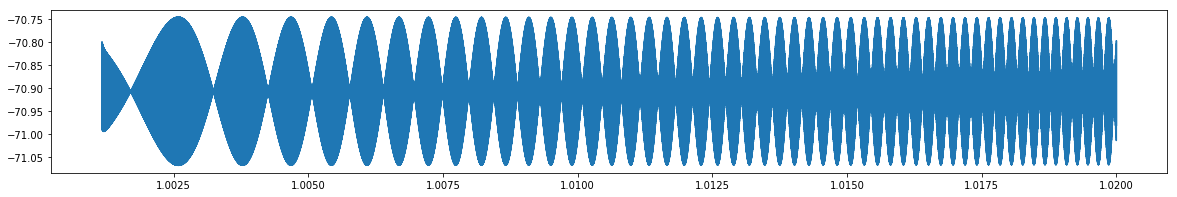

In [26]:
plt.figure(figsize=(20,3))
plt.plot(freq[4500:], myNeuron.u[4500:])
plt.show()

---

#### MHH neuron response to TI stimulation at the superficial regions

In [27]:
I1 = fn.gen_sin(init_time=0,
                freq=1.0,
                phase=0,
                time_points=mySim.t)

I2 = fn.gen_sin(init_time=0,
                freq=1.01,
                phase=0,
                time_points=mySim.t)

I = I1 + I2

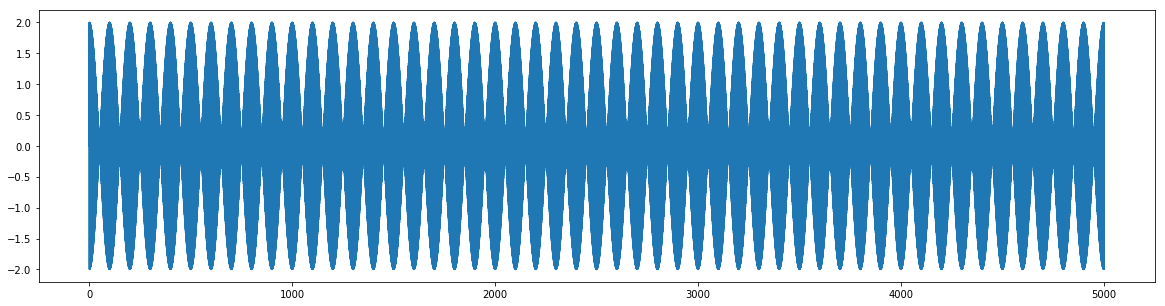

In [28]:
plt.figure(figsize=(20,5))
plt.plot(mySim.t, I)

In [ ]:
for i in range(I.shape[0]-1):
    myNeuron.update(i, mySim.dt)
    dudt = (myNeuron.INA[i] + myNeuron.IK[i] + myNeuron.IA[i] + myNeuron.IL + I[i]) / myNeuron.C
    myNeuron.u[i+1] = myNeuron.u[i] + mySim.dt * dudt

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(freq[4500:], myNeuron.u[4500:])
plt.show()

---

#### MHH neuron response to TI stimulation at depth

In [29]:
I1 = fn.gen_sin(init_time=0,
                freq=1.0,
                phase=0,
                time_points=mySim.t)

I2 = fn.gen_sin(init_time=0,
                freq=1.01,
                phase=0,
                time_points=mySim.t)

I = I1 + I2

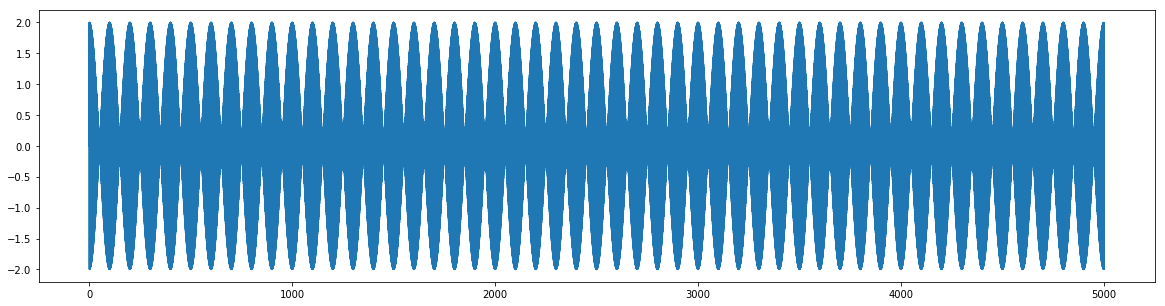

In [30]:
plt.figure(figsize=(20,5))
plt.plot(mySim.t, I)

In [ ]:
for i in range(I.shape[0]-1):
    myNeuron.update(i, mySim.dt)
    dudt = (myNeuron.INA[i] + myNeuron.IK[i] + myNeuron.IA[i] + myNeuron.IL + I[i]) / myNeuron.C
    myNeuron.u[i+1] = myNeuron.u[i] + mySim.dt * dudt

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(freq[4500:], myNeuron.u[4500:])
plt.show()

---

#### MHH neuron response to direct 10 Hz stimulation

In [31]:
I = fn.gen_sin(init_time=0,
               freq=.01,
               phase=0,
               time_points=mySim.t)

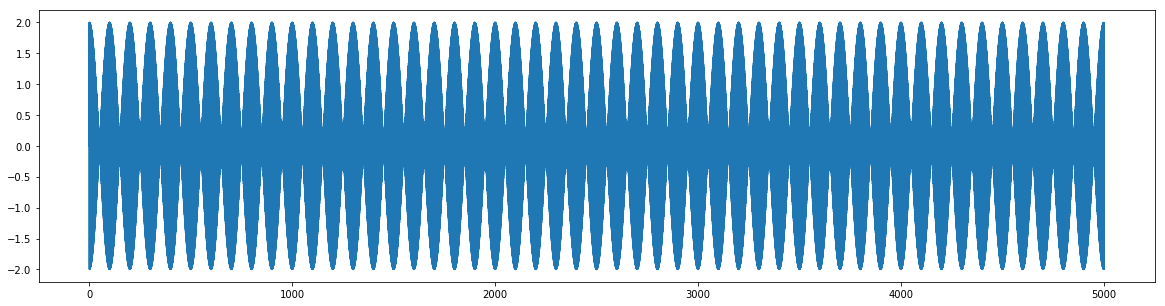

In [33]:
plt.figure(figsize=(20,5))
plt.plot(mySim.t, I)

In [ ]:
for i in range(I.shape[0]-1):
    myNeuron.update(i, mySim.dt)
    dudt = (myNeuron.INA[i] + myNeuron.IK[i] + myNeuron.IA[i] + myNeuron.IL + I[i]) / myNeuron.C
    myNeuron.u[i+1] = myNeuron.u[i] + mySim.dt * dudt

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(freq[4500:], myNeuron.u[4500:])
plt.show()

---

#### MHH neuron response to AM 10 Hz stimulation

In [32]:
I1 = fn.gen_sin(init_time=0,
                freq=1.0,
                phase=0,
                time_points=mySim.t)

I2 = fn.gen_sin(init_time=0,
                freq=1.01,
                phase=0,
                time_points=mySim.t)

I = I1 + I2

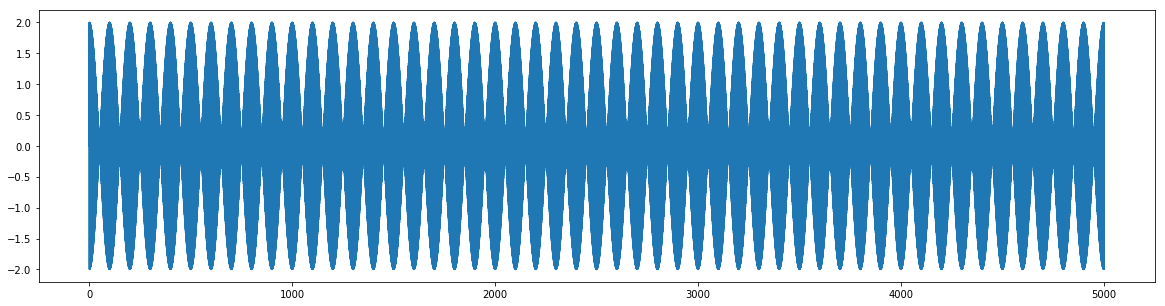

In [34]:
plt.figure(figsize=(20,5))
plt.plot(mySim.t, I)

In [ ]:
for i in range(I.shape[0]-1):
    myNeuron.update(i, mySim.dt)
    dudt = (myNeuron.INA[i] + myNeuron.IK[i] + myNeuron.IA[i] + myNeuron.IL + I[i]) / myNeuron.C
    myNeuron.u[i+1] = myNeuron.u[i] + mySim.dt * dudt

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(freq[4500:], myNeuron.u[4500:])
plt.show()

---